## Building a CNN to classify images.


### รูปภาพที่ให้มามี 4 คลาส โดยมีหมายเลขคลาสดังนี้:
<ol start="0">
<li> frog
<li> cat
<li> dog
<li> horse
</ol>

In [1]:
import time, datetime
import requests, pickle
import numpy as np
from tensorflow import keras
from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random, os, tensorflow as tf

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # to Disable GPU training

In [3]:
print('Default GPU Device:', tf.test.gpu_device_name() or 'None')

Default GPU Device: None


In [4]:
class_names = ['frog', 'cat', 'dog', 'horse']

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(open('364_midterm_data.pkl', "rb"))

# url = "https://drive.google.com/uc?id=1v6wfLWvOzq2Aaw7MuhnkZd1VRCgLTh4b"
# (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.loads(requests.get(url).content)

### ดูรูปภาพในชุดข้อมูล

In [5]:
def show_images(X, y, class_names, n_rows=3, n_cols=8, figsize=(9, 4)):
    fig = plt.figure(figsize=figsize)
    for i in range(0, n_rows):
        for j in range(0, n_cols):
            idx = i*n_cols + j
            image = X[idx]
            label = class_names[y[idx][0]]        
            ax = plt.subplot(n_rows, n_cols, idx+1)
            plt.imshow(image)
            plt.text(16, 36, str(y[idx]) + ' - ' + label, ha='center')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

[0] frog


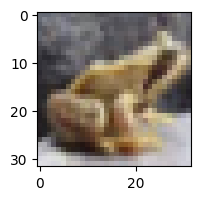

In [6]:
print(y_test[1], class_names[y_test[1][0]])
plt.figure(figsize=(2, 2))
plt.imshow(X_test[1])

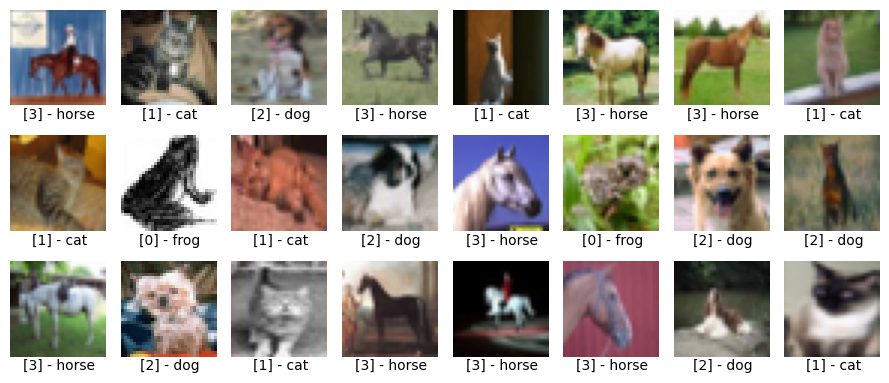

In [7]:
show_images(X_train, y_train, class_names, 3, 8)

### Normalize images and One-Hot Encode labels

In [8]:
n_classes = len(class_names)

y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [9]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

<style> h3 { margin-top: 0.5em !important; margin-bottom: 0.0em; }
        h4 { margin-top: 0.1em !important; margin-bottom: 0.1em; }
        h5 { margin-top: 0.0em; margin-bottom: 0.2em; } </style>

# <span style="color:blue">โจทย์คำถาม</span>
* ### เพื่อป้องกันผลกระทบจาก randomness ให้นิสิตใช้ค่า seed เป็น 12345 ในทุกกรณีที่เกี่ยวข้องกับการสุ่ม และให้เรียกใช้ฟังก์ชัน set_seed(12345) ทุกครั้งก่อนที่จะสร้างโมเดล
* ### ให้สร้างโมเดลด้วย CNN เพื่อให้ได้ accuracy ที่ดีที่สุด และห้ามใช้ Early Stopping หรือใช้ Best Weights ในการเทรนโมเดล โดยให้เทรนโมเดลเต็มจำนวน epoch ที่นิสิตกำหนด โดยค่า epoch ต้องไม่น้อยกว่า 50 และต้องหารด้วย 20 ลงตัว
  * #### (10 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.65
  * #### (15 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.70
  * #### (20 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.73
  * #### (25 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.75
  * #### (30 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.80
  * #### (35 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.83
  * #### (40 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.85
  * #### (50 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.90  
* ### (25 คะแนน) ให้แสดงกราฟ Loss และ Accuracy ของโมเดลที่เกิดจากการเทรนโมเดล และหลังจากโมเดลถูกเทรนแล้วเสร็จ ให้แสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train, validation และ test
* ### (25 คะแนน) ให้แสดง Confusion Matrix ผลการทำนายที่ได้จากโมเดลด้วยข้อมูลเทส
  ##### บอกใบ้ จากโค้ดข้างล่าง ค่าข้อมูลแต่ละตัวใน y_pred (ที่ได้จาก model.predict(...)) และ y_test จะมี 4 จำนวน (ตามจำนวนคลาส) โดยใน y_pred จะเก็บค่าความน่าจะเป็นที่อินพุต X_test จะเป็นแต่ละคลาส เช่น [0.6, 0.05, 0.15, 0.2] ซึ่งหมายถึง ความน่าจะเป็นที่อินพุตจะเป็นคลาส 0 มีค่าเป็น 0.6 และในลักษณะเดียวกัน y_test จะเก็บค่าผลเฉลยซึ่งอยู่ในรูป One-Hot Encoding เช่น [0, 0, 0, 1] ซึ่งหมายถึง ผลเฉลยของอินพุตเป็นคลาส 3 เป็นต้น เราใช้ np.argmax(...) เพื่อแปลงค่าที่อยู่ในรูปเวกเตอร์ให้กลายเป็นค่าสเกลาร์ เพื่อความสะดวกในการเปรียบเทียบระหว่างผลทำนายกับผลเฉลย
    ```python
    y_pred = model.predict(X_test, verbose=0)
    y_test_1d = np.argmax(y_test, axis=1
    y_pred_1d = np.argmax(y_pred, axis=1)
    ```
  ##### ในโมดูล sklearn ภายใต้ metrics มีฟังก์ชัน confusion_matrix(...) ที่ใช้คำนวณ Confusion Matrix<br>
* ### (25 คะแนน) ให้คำนวณค่า Recall ของแต่ละคลาสด้วยข้อมูลเทส โดยให้เขียนตอบในรูปนิพจน์ตามตัวอย่างด้านล่าง ซึ่งค่า Recall บ่งบอกถึงความสามารถของโมเดลในการทำนายคลาสที่สนใจได้อย่างถูกต้อง โดยโมเดลที่มีค่า Recall สูงบ่งบอกถึงโมเดลสามารถทำนายคลาสที่สนใจได้ถูกต้องเป็นจำนวนมาก ค่า Recall คำนวณได้จากสูตรข้างล่างนี้ <br><br> $$ Recall = {TruePositives \over TruePositives + FalseNegatives} $$ 
### จากตัวอย่างในตาราง Confusion Matrix ด้านล่างนี้ ค่า Recall ของคลาส Apple คำนวณได้จาก 7 / (7 + 1 + 3) = 0.6364 ส่วนของคลาส Orange คำนวณได้จาก 2 / (2 + 8 + 2) = 0.1667 และของคลาส Mango คำนวณได้จาก 1 / (1 + 9 + 3) = 0.0769

 <center><img src="https://drive.google.com/thumbnail?id=1v8N__pdOnfAV-JwBR4rfKJdTSqOSeAv4&sz=w500"></center>

* ### (โบนัส 20 คะแนน) จงเปรียบเทียบและอธิบายค่า Recall ที่คำนวณได้จากทั้ง 4 คลาส และให้แสดงภาพจำนวน 5 ภาพที่มาจากคลาสที่มีค่า Recall สูงสุดแต่โมเดลทำนายผิด โดยให้แสดงค่าคลาสของแต่ละภาพที่โมเดลทำนายออกมาด้วย

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix

In [69]:
print(y_train[:5])
print(y_train.shape)


[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
(19200, 4)


In [109]:
print(X_train.shape)

(19200, 32, 32, 3)


In [70]:
print(X_train.min(), X_train.max())


0.0 1.0


In [71]:
import numpy as np
print(np.unique(np.argmax(y_train, axis=1), return_counts=True))


(array([0, 1, 2, 3], dtype=int64), array([4800, 4800, 4800, 4800], dtype=int64))


In [194]:
seed = 12345
set_seed(seed)

batch_size = 64
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                            
                                                                 
 flatten_41 (Flatten)        (None, 576)               0         
                                                                 
 dense_121 (Dense)           (None, 32)              

In [195]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
300/300 [==============================] - 6s 20ms/step - loss: 1.3441 - accuracy: 0.3407 - val_loss: 1.2367 - val_accuracy: 0.4750
Epoch 2/100
300/300 [==============================] - 6s 20ms/step - loss: 1.1957 - accuracy: 0.4672 - val_loss: 1.1052 - val_accuracy: 0.5404
Epoch 3/100
300/300 [==============================] - 6s 20ms/step - loss: 1.0948 - accuracy: 0.5201 - val_loss: 1.0117 - val_accuracy: 0.5567
Epoch 4/100
300/300 [==============================] - 6s 21ms/step - loss: 1.0433 - accuracy: 0.5508 - val_loss: 0.9552 - val_accuracy: 0.5975
Epoch 5/100
300/300 [==============================] - 7s 22ms/step - loss: 1.0019 - accuracy: 0.5692 - val_loss: 0.9184 - val_accuracy: 0.6075
Epoch 6/100
300/300 [==============================] - 7s 22ms/step - loss: 0.9783 - accuracy: 0.5820 - val_loss: 0.8982 - val_accuracy: 0.6271
Epoch 7/100
300/300 [==============================] - 7s 23ms/step - loss: 0.9518 - accuracy: 0.5928 - val_loss: 0.8792 - val_accuracy:

In [196]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(X_train, y_train, verbose=0)))

Train Loss: 0.430118, Accuracy: 0.828542


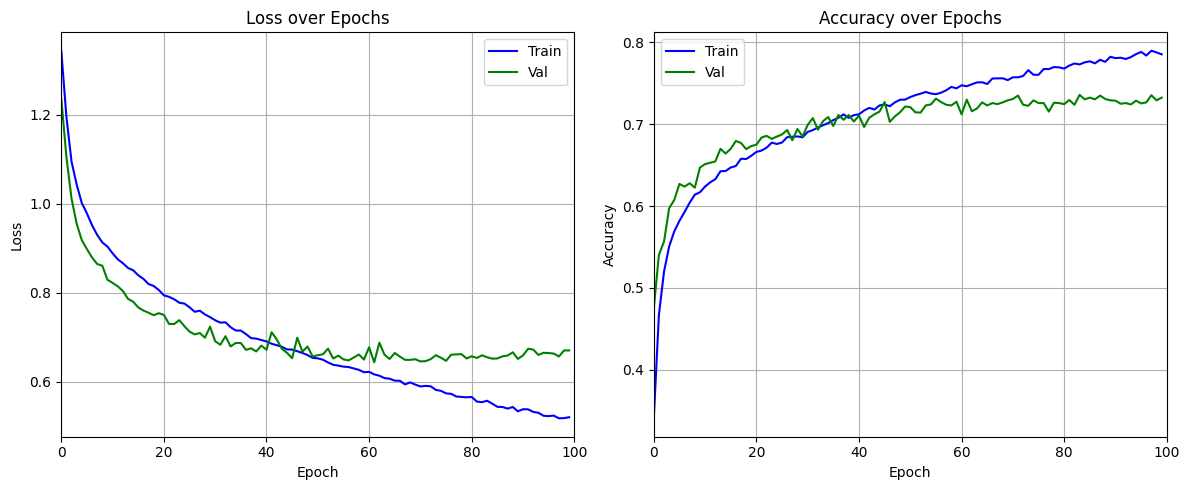

In [197]:
fig, (ax1_2, ax2_2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Plot Loss ---
ax1_2.plot(history.history["loss"], 'b', label="Train")
ax1_2.plot(history.history["val_loss"], 'g', label="Val")
ax1_2.set_title("Loss over Epochs")
ax1_2.set_xlabel("Epoch")
ax1_2.set_ylabel("Loss")
ax1_2.grid(True)
ax1_2.set_xlim(0, len(history.history["loss"]))
ax1_2.legend()

# --- Plot Accuracy ---
ax2_2.plot(history.history["accuracy"], 'b', label="Train")
ax2_2.plot(history.history["val_accuracy"], 'g', label="Val")
ax2_2.set_title("Accuracy over Epochs")
ax2_2.set_xlabel("Epoch")
ax2_2.set_ylabel("Accuracy")
ax2_2.grid(True)
ax2_2.set_xlim(0, len(history.history["accuracy"]))
ax2_2.legend()

plt.tight_layout()
plt.show()

In [198]:
y_test_1d = np.argmax(y_test, axis=1)

y_pred = model.predict(X_test, verbose=0)
y_pred_1d = np.argmax(y_pred, axis=1)

In [199]:
from sklearn.metrics import accuracy_score

In [200]:
y_pred_train = model.predict(X_train)
y_pred_train_1d = np.argmax(y_pred_train, axis=1)
y_pred_val = model.predict(X_val)
y_pred_val_1d = np.argmax(y_pred_val, axis=1)

print('Accuracy for each set:')
print(f"Train: {accuracy_score(np.argmax(y_train, axis=1), y_pred_train_1d):.4f}")
print(f"Validation: {accuracy_score(np.argmax(y_val, axis=1), y_pred_val_1d):.4f}")
print(f"Test: {accuracy_score(np.argmax(y_test, axis=1), y_pred_1d):.4f}")


75/75 [==============================] - 0s 3ms/step
Accuracy for each set:
Train: 0.8285
Validation: 0.7325
Test: 0.7308


In [23]:
unique, counts = np.unique(y_test_1d, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{class_names[label]} ({label}): {count}")

frog (0): 600
cat (1): 600
dog (2): 600
horse (3): 600


In [20]:
import seaborn as sns

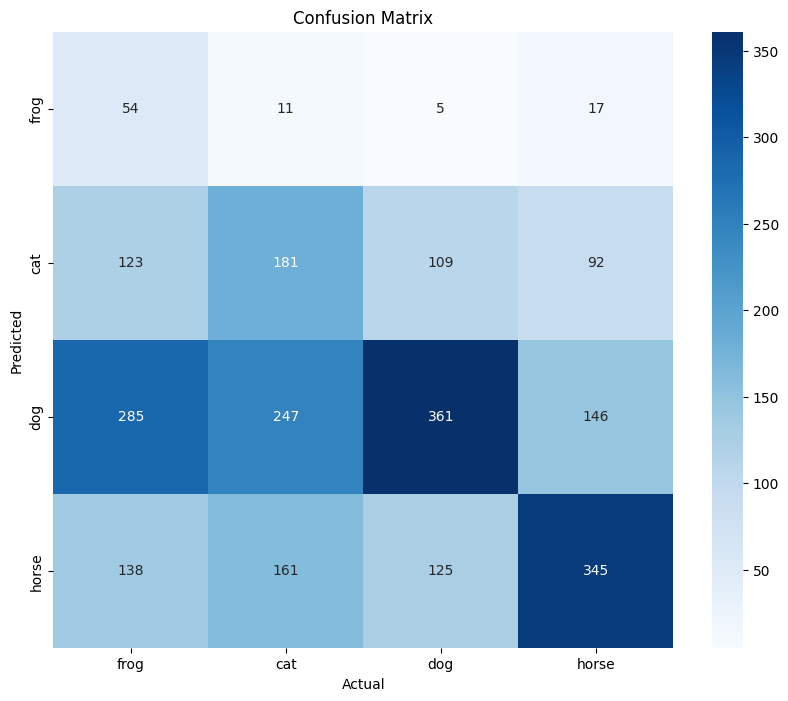

In [24]:
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d, labels=np.arange(n_classes))
cm = cm.T
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Recall : TP / (TP + FN)
# print(np.diag(cm))
# print(np.sum(cm, axis=0))

print('Recall for each class:')
recall = np.diag(cm) / np.sum(cm, axis=0)
for i, label in enumerate(class_names):
    print(f"{label:5} : {recall[i]:.4f}")

Recall for each class:
frog  : 0.0900
cat   : 0.3017
dog   : 0.6017
horse : 0.5750


จากการคำนวณ Recall คลาสที่มี Recall สูงที่สุดคือ dog, หมายความค่าโมเดลมีความสามารถในการระบุคลาส dog มากกว่าคลาสอื่นๆ

Class with highest recall: dog
Misclassified sample 0:
Predicted label: cat


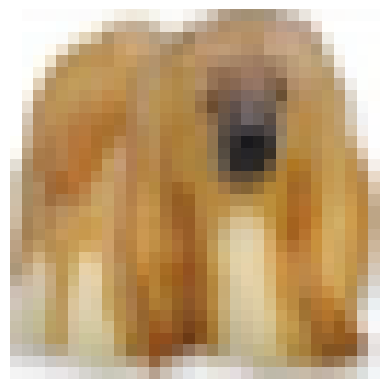

Misclassified sample 1:
Predicted label: cat


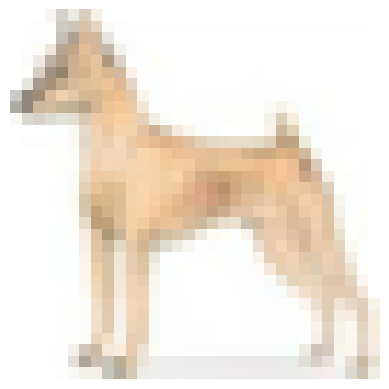

Misclassified sample 2:
Predicted label: cat


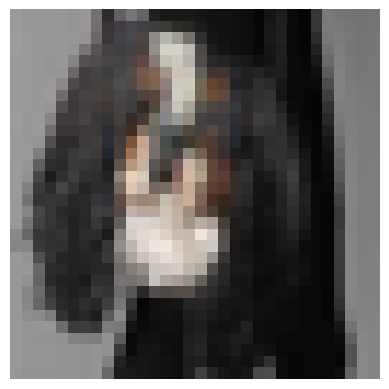

Misclassified sample 3:
Predicted label: horse


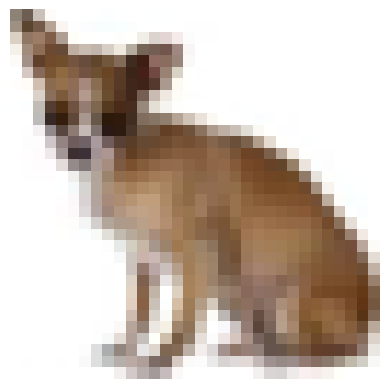

Misclassified sample 4:
Predicted label: cat


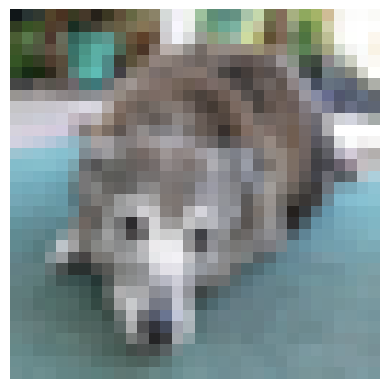

In [ ]:
highest_recall_class = np.argmax(recall)

indices = np.where((y_test_1d == highest_recall_class) & (y_pred_1d != highest_recall_class))[0]
print(f'Class with highest recall: {class_names[highest_recall_class]}')
print()
for i in range(5):
    print(f"Misclassified sample {i}:")
    print(f"Predicted label: {class_names[y_pred_1d[indices[i]]]}")
    plt.imshow(X_test[indices[i]])
    plt.axis('off')
    plt.show()
